In [1]:
#Importing libraries

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchsummary import summary
from torch import nn
import torch.nn
from torch.functional import F
from tqdm import tqdm
import copy
import time
from torchsummary import summary
device = "cuda" if torch.cuda.is_available else "cpu"
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
print(os.getcwd())
os.chdir(os.pardir)
os.chdir(os.pardir)

print(os.getcwd())
data_dir = "..\Python Projects\Datasets\Garbage classification\Garbage classification"
os.path.exists(data_dir)

d:\Python Projects\CV\GarbageClassification
d:\Python Projects


True

In [3]:
#Data transformations

train_transforms = transforms.Compose([
        transforms.Resize(224),
        # transforms.Grayscale(),
        # transforms.RandomResizedCrop(size=50),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.6732, 0.6399, 0.6050],[0.1809, 0.1801, 0.1907]) # Calculate mean and variance of entire dataset, check this value
    ])

test_transforms = transforms.Compose([
        transforms.Resize(224),
        # transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize([0.6732, 0.6399, 0.6050],[0.1809, 0.1801, 0.1907])
    ])

In [4]:
#Loading testing train-test split
def preprocessing(datadir):
    train_data = datasets.ImageFolder(datadir)
    return train_data

data = preprocessing(data_dir)
print(type(data))

<class 'torchvision.datasets.folder.ImageFolder'>


In [5]:

class MapDataset(torch.utils.data.Dataset):
    """
    Given a dataset, creates a dataset which applies a mapping function
    to its items (lazily, only when an item is called).

    Note that data is not cloned/copied from the initial dataset.
    """

    def __init__(self, dataset, map_fn=None):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  # image
        y = self.dataset[index][1]   # label      
        return x, y

    def __len__(self):
        return len(self.dataset)

In [6]:
# obtain training indices that will be used for validation
test_size = 0.2
num_train = len(data)
# print(num_train)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# print(split)
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trn_data_tf = MapDataset(data, train_transforms)
test_data_tf = MapDataset(data, test_transforms)

train_loader = DataLoader(trn_data_tf, batch_size=32, pin_memory=True, sampler=train_sampler)
test_loader = DataLoader(test_data_tf, batch_size=32, pin_memory=True, sampler=valid_sampler)

In [7]:
# data_loader = iter(train_loader)
# images, labels = (data_loader.next())

In [8]:
# figure = plt.figure(figsize=(15,10))
# NUM_IMAGES = 25

# for idx in range(1,NUM_IMAGES+1):
#     plt.subplot(5,5, idx)
#     plt.axis('off')

#     plt.imshow(images[idx].numpy().squeeze(), cmap='gray')
#     plt.title(labels[idx].numpy())

In [9]:
# View some examples of images
# raise ValueError()

In [10]:
DROPOUT = 0
 
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3,32,3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(DROPOUT)
         ) #1 48 Input 3, 16 output 3*3 Square convolutions

        self.conv2 = nn.Sequential(
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(DROPOUT),
            nn.MaxPool2d(2,2)
            ) # 23/24 Input, 16 output 3*3 Square convolutions

        self.conv3 = nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(DROPOUT),
         ) # 22 Input, 16 output 3*3 Square convolutions

        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(DROPOUT)
         ) # 20 Input, 16 output 3*3 Square convolutions

        self.conv5 = nn.Sequential(
            nn.Conv2d(64,32,1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(DROPOUT)
            ) # 18 Input, 16 output 3*3 Square convolutions
        #Fully connected layers

        self.conv6 = nn.Sequential(
            nn.Conv2d(32,64,3, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(DROPOUT)
            ) # 9

        self.conv7 = nn.Sequential(
            nn.Conv2d(64,64,1, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(DROPOUT)
            ) # 7


        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=10)
        ) # 8

        self.conv8 = nn.Sequential(
            nn.Conv2d(64,6,1)
        ) # 8

    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.gap(x)
        x = self.conv8(x)
        x = x.view(-1,6)
        return F.log_softmax(x, dim=1)
 
    # def num_flat_features(self, x):
    #     size = x.size()[1:] #All dimensions except batch dimensions
    #     num_features = 1
    #     for s in size:
    #         num_features *=s
    #     return num_features
    


In [11]:
model = Net().to(device)
summary(model, input_size=(3,224,298))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 296]             896
              ReLU-2         [-1, 32, 222, 296]               0
       BatchNorm2d-3         [-1, 32, 222, 296]              64
           Dropout-4         [-1, 32, 222, 296]               0
            Conv2d-5         [-1, 64, 220, 294]          18,496
              ReLU-6         [-1, 64, 220, 294]               0
       BatchNorm2d-7         [-1, 64, 220, 294]             128
           Dropout-8         [-1, 64, 220, 294]               0
         MaxPool2d-9         [-1, 64, 110, 147]               0
           Conv2d-10         [-1, 64, 108, 145]          36,928
             ReLU-11         [-1, 64, 108, 145]               0
      BatchNorm2d-12         [-1, 64, 108, 145]             128
          Dropout-13         [-1, 64, 108, 145]               0
           Conv2d-14         [-1, 64, 1

In [12]:
#Training the model
train_acc = []
train_loss = []

test_acc = []
test_losses = []

model_path = "" # Path to save the model

def train_model(model, train_dataloader, optimizer):
    since =  time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
   
    #Each epoch has training and validation set

    model.train()     
    loss = 0.0
    correct = 0
    processed = 0
    
    pbar = tqdm(train_dataloader)
    #Iterate over data
    for batch_index, (inputs, labels) in enumerate(pbar):

        # Moving target and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # zero the parameter gradients
        outputs = model(inputs)
        _,preds = torch.max(outputs,1)
        loss = F.nll_loss(outputs, labels)
        train_loss.append(loss)
        loss.backward()
        optimizer.step()

        correct += preds.eq(labels.view_as(preds)).sum().item()
        processed += len(data)
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_index} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test_model(model, test_dataloader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():

        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))
    
    test_acc.append(100. * correct / len(test_dataloader.dataset))

In [13]:
# type(optimizer)

In [14]:
optimizer = torch.optim.SGD(params=model.parameters(),lr = 0.01, momentum=0.9)
EPOCHS = 5
for epoch in range(EPOCHS):
    print(f'Epoch {epoch} / {EPOCHS-1}')
    train_model(model, train_loader, optimizer)
    test_model(model, test_loader)
    print('-'*10)

0%|          | 0/64 [00:00<?, ?it/s]Epoch 0 / 4
Loss=1.2800116539001465 Batch_id=63 Accuracy=0.61: 100%|██████████| 64/64 [00:54<00:00,  1.18it/s]
  0%|          | 0/64 [00:00<?, ?it/s]
Test set: Average loss: 0.2710, Accuracy: 243/2534 (9.59%)

----------
Epoch 1 / 4
Loss=1.7719088792800903 Batch_id=63 Accuracy=0.68: 100%|██████████| 64/64 [00:47<00:00,  1.35it/s]
  0%|          | 0/64 [00:00<?, ?it/s]
Test set: Average loss: 0.2792, Accuracy: 249/2534 (9.83%)

----------
Epoch 2 / 4
Loss=1.0731220245361328 Batch_id=63 Accuracy=0.71: 100%|██████████| 64/64 [00:53<00:00,  1.19it/s]
  0%|          | 0/64 [00:00<?, ?it/s]
Test set: Average loss: 0.2792, Accuracy: 236/2534 (9.31%)

----------
Epoch 3 / 4
Loss=0.9526113867759705 Batch_id=63 Accuracy=0.73: 100%|██████████| 64/64 [00:57<00:00,  1.11it/s]
  0%|          | 0/64 [00:00<?, ?it/s]
Test set: Average loss: 0.2284, Accuracy: 283/2534 (11.17%)

----------
Epoch 4 / 4
Loss=1.704756259918213 Batch_id=63 Accuracy=0.74: 100%|██████████| 

Text(0.5, 1.0, 'Test Accuracy')

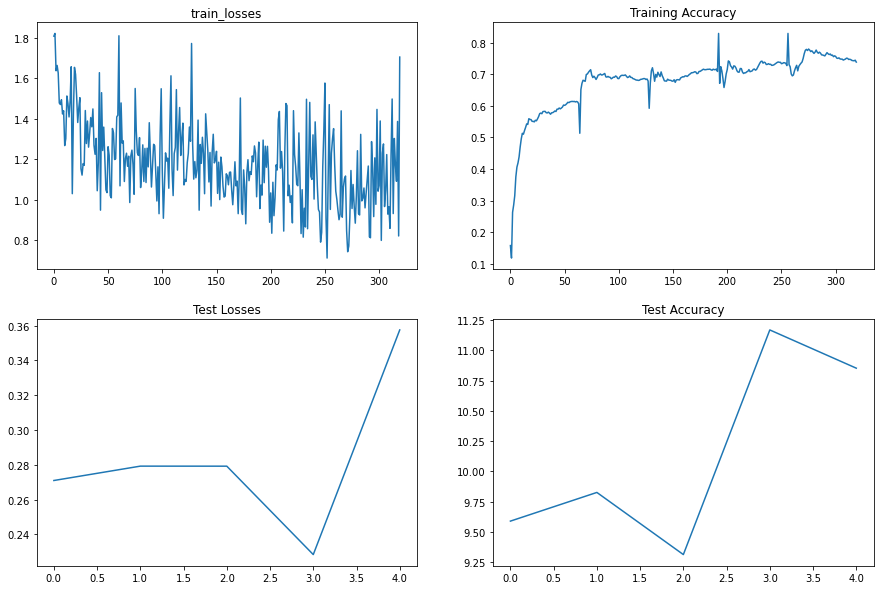

In [17]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(train_loss)
axs[0,0].set_title('train_losses')
axs[0,1].plot(train_acc)
axs[0,1].set_title('Training Accuracy')
axs[1,0].plot(test_losses)
axs[1,0].set_title('Test Losses')
axs[1,1].plot(test_acc)
axs[1,1].set_title('Test Accuracy')

In [16]:

def plot_misclassified(misclassified:list):    
    plt.figure(figsize=(20,20))
    for plotIndex, badIndex in enumerate(misclassified[0:25]):
        plt.subplot(5, 5, plotIndex + 1,)
        plt.axis('off')
        plt.imshow(np.reshape(misclassified[plotIndex][0].cpu(), (28,28)), cmap=plt.cm.gray)
        plt.title("Predicted: {}, Actual: {}".format(misclassified[plotIndex][1], misclassified[plotIndex][2].cpu().numpy(), fontsize = 20))
        plt.savefig(os.path.join(img_dir,'misclassified.png'))